In [4]:
!pip install myqlm
!apt install imagemagick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 KB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.3/498.3 KB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 KB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 KB 7.

In [5]:
!python3 -m qat.magics.install

QLM magics have been sucessfully installed


## Part 1 implementing QAOA


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_z^i \cdot \sigma_z^j $$

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [17]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits) # si x=3, b='00011'
    b = [int(b[i]) for i in range(nqubits)]
    # TODO: Complete the computation below:
    val=0
    for edge in edges:
      num1=edge[0]
      num2=edge[1]
      if ((b[num1]==1) and (b[num2]==0)) or ((b[num1]==0) and (b[num2]==1)):
        val-=1
      else:
        val+=1
    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)

def Calculate_Hamiltonian(edges,x_bit):
  Hamiltonian=0
  for edge in edges:
    num1=edge[0]
    num2=edge[1]
    Hamiltonian+=(1-2*x_bit[num1])*(1-2*x_bit[num2])
  return Hamiltonian
print(Calculate_Hamiltonian(edges,best_b))

-5
[1, 0, 0, 1, 1]
-5


#### visualization of the graph

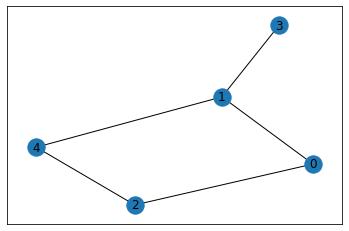

In [2]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [3]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [4]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

In [10]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()
    #TODO: implement one qaoa layer
    for i in range(n_qubits):
      layer.apply(RX(theta),i)
    for edge in edges:
      layer.apply(U_ZZ(beta),edge[0],edge[1])

    
    return layer

### Question 4

In [11]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit
    for i in range(n_qubits):
      prog.apply(H,qubits[i])
    for i in range(n_layers):    
      prog.apply(one_qaoa_layer(n_qubits, edges, parameters[2*i], parameters[2*i+1]),qubits)

        
    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    # BEGIN TODO
    obs = 0
    for sample in result:
        # this loop is over all 2**nqubits states.
        # sample.state.bitstring contains the qubit values (nqubits 0 or 1)
        x_bit=list(map(int,list(sample.state.bitstring)))
        prob=sample.probability
        obs+=Calculate_Hamiltonian(edges,x_bit)*prob

    # END TODO
    return obs
    
        

In [7]:
import numpy as np
np.random.random(3)

array([0.82149003, 0.7582733 , 0.23714044])

In [8]:
from scipy.optimize import minimize


### Random initialisation

### Question 5: 
réponse à la question:9

-0.23406385653284922 -0.6216144422194426 -1.0695944340074885 -1.3057292401996574 -1.482974982473742 -1.5748706878190049 -1.7173787600953527 -1.7498951205140492 -1.8106123441499744 -2.399291025604767 -2.553576409176887 -2.777796432622601 -2.969844451879275 -3.0973915553517593 -3.324850820422597 -3.6205865323348316 -3.709010724382461 -3.8157939611301375 -3.9451204660381656 -4.059018251385445 -4.110596484006958 -4.193277833093436 -4.242022772748547 -4.304537122257376 -4.342728324551018 -4.382046118956488 -4.393331342991102 -4.403860423225805 -4.415336844244601 -4.427149073589363 -4.435321080794562 -4.443391644718301 -4.452321081764737 -4.463466802361262 -4.47482551826989 -4.492404408363626 -4.507938486004028 -4.532985822362769 -4.566210543509842 -4.581302746105799 -4.601578168781949 -4.620370670363816 -4.630865778337662 -4.642651033747717 -4.649684028034748 -4.652146217562171 -4.655679242946155 -4.65724663484421 -4.6574969378236935 -4.65774679939437 -4.658049261998402 -4.658372884245135 -

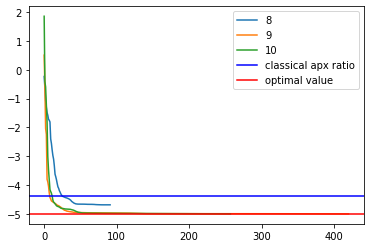

In [18]:
import matplotlib.pylab as plt


for nlayers in range(8,11,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

### Question 6: smart initialization

-0.4040364558443024 -1.6451988236091197 -2.3947521925683604 -3.146416792379957 -3.1891919744450923 -3.218601194787409 -3.2253530923614324 -3.2260671504291762 -3.2260696302241536 -3.226069647206931 -3.2260696472290524 -1.6826058482852893 -2.6615514837749887 -2.889728543529119 -3.623846426827342 -3.670672405683039 -3.759944451051686 -3.917522878754114 -4.117832203894159 -4.1520967041675165 -4.178437089557348 -4.200961214817412 -4.23337835111092 -4.285853215842089 -4.3334087545699225 -4.339773679105125 -4.349567706820618 -4.365947166464228 -4.392182301429377 -4.428889271224552 -4.450512399641948 -4.456043649499483 -4.463136140405774 -4.463827877174874 -4.463832318834786 -4.463832624123568 -4.4638326322030295 -4.463832632301585 -0.1164333374580308 -2.4985814126090085 -3.4062826231956533 -3.8958814724303323 -4.037095649323113 -4.081491295912318 -4.143861089409081 -4.169445488201207 -4.211309212783348 -4.259573246289563 -4.318195502446467 -4.384777601853983 -4.419453642939059 -4.435553016167

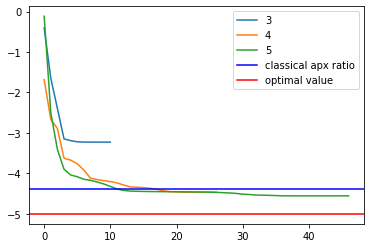

In [26]:
T = 2.

for nlayers in range(3,6,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []
    for k in range(1,nlayers+1):
      parameters_init.append(2*T/nlayers*(1-k/nlayers))
      parameters_init.append(k*T/nlayers**2)

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))

plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()